## MSDS458 Research Assignment 02 Experiments

Experiment 1: DNN with 2 layers (no regularization)

Experiment 2: DNN with 3 layers (no regularization)

Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

Experiment 5+ : You will conduct several more experiments. 
(a) Redo all the 4 experiments with some regularization technique. 
(b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [ ]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


### Mount Google Drive to Colab Environment

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Functions for Research Assignment

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

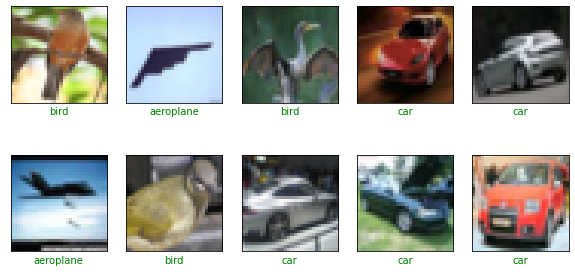

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

### Create Validation Data Set

In [ ]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

### Confirm Datasets {Train, Validation, Test}

In [ ]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


In [ ]:
"""
#Build CNN Model
#We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. The last 3 layers, handle classification
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))
"""

'\n#Build CNN Model\n#We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. The last 3 layers, handle classification\nmodel = models.Sequential()\nmodel.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))\nmodel.add(layers.MaxPool2D((2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))\nmodel.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))\nmodel.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Flatten())\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))\nmodel.add(layers.D

In [ ]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

'model1'

In [79]:
import datetime as dt

def compile_train_model_with_reg(model, epoch, batch):
  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model
  history = model.fit(x_train_norm
                      ,y_train_split
                      ,epochs=epoch
                      ,batch_size=batch
                      ,validation_data=(x_valid_norm, y_valid_split)
                      ,callbacks=[
                      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # remove early stop so that we can see if the model is able to overfit
                      #tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                      #                    save_weights_only=False, monitor='val_accuracy')
                      ]                                                                                                           
                    )

  #evaluate model
  loss, accuracy = model.evaluate(x_test_norm, y_test)
  print('test set accuracy: ', accuracy * 100)

  #predict model
  preds = model.predict(x_test_norm)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs'] = epoch  
  result['batch_size'] = batch    

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs and {2} batch size'.format(namestr(model, globals()), epoch, batch))   
  plt.show()  

  return result

In [78]:
import datetime as dt

def compile_train_plot_model(model, epoch, batch):
  #plot model
  keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model
  history = model.fit(x_train_norm
                      ,y_train_split
                      ,epochs=epoch
                      ,batch_size=batch
                      ,validation_data=(x_valid_norm, y_valid_split)
                      #,callbacks=[
                      #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                      #tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                      #                    save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                    )

  #evaluate model
  loss, accuracy = model.evaluate(x_test_norm, y_test)
  print('test set accuracy: ', accuracy * 100)

  #predict model
  preds = model.predict(x_test_norm)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs'] = epoch  
  result['batch_size'] = batch    

  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  #loss and accuracy for training and validation data
  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs and {2} batch size'.format(namestr(model, globals()), epoch, batch))          
  plt.show()                        

  #confuison matrix
  pred1= model.predict(x_test_norm)
  pred1=np.argmax(pred1, axis=1)
  print_validation_report(y_test, pred1)
  plot_confusion_matrix(y_test,pred1)

  return result


### Experiment 1: DNN with 2 layers (no regularization)

In [81]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(32, 32, 3)))
model1.add(layers.Flatten(name ='flatten'))
model1.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model1.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 3s 6ms/step - loss: 1.9596 - accuracy: 0.3082 - val_loss: 1.8252 - val_accuracy: 0.3576
Epoch 2/20
450/450 [==============================] - 2s 5ms/step - loss: 1.7407 - accuracy: 0.3812 - val_loss: 1.7057 - val_accuracy: 0.3872
Epoch 3/20
450/450 [==============================] - 2s 5ms/step - loss: 1.6647 - accuracy: 0.4080 - val_loss: 1.6643 - val_accuracy: 0.4032
Epoch 4/20
450/450 [==============================] - 2s 5ms/step - loss: 1.6192 - accuracy: 0.4250 - val_loss: 1.6584 - val_accuracy: 0.4040
Epoch 5/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5776 - accuracy: 0.4423 - val_loss: 1.6162 - val_accuracy: 0.4156
Epoch 6/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5475 - accuracy: 0.4531 - val_loss: 1.6302 - val_accuracy: 0.4132
Epoch 7/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5270 - accuracy: 0.4576 - val_loss: 1.5713 - val_accuracy: 0.4382
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

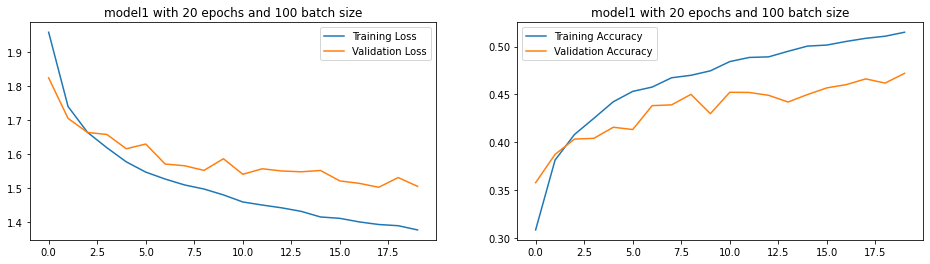

Classification Report
              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1000
           1       0.69      0.43      0.53      1000
           2       0.33      0.43      0.37      1000
           3       0.33      0.31      0.32      1000
           4       0.41      0.41      0.41      1000
           5       0.37      0.43      0.40      1000
           6       0.54      0.52      0.53      1000
           7       0.61      0.48      0.54      1000
           8       0.54      0.65      0.59      1000
           9       0.54      0.58      0.56      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.48     10000
weighted avg       0.49      0.48      0.48     10000

Accuracy Score: 0.4785
Root Mean Square Error: 3.1223548805348824


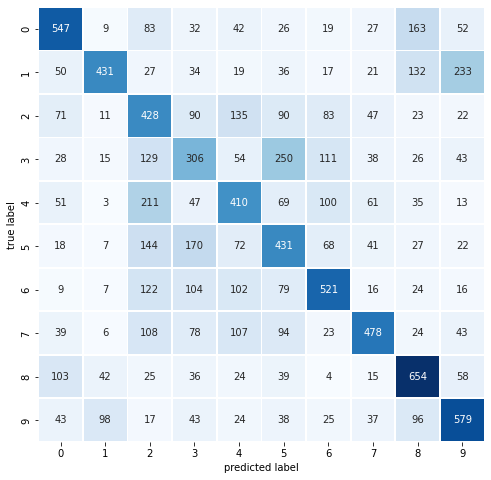

In [82]:
result1 = compile_train_plot_model(model1, 20, 100)

In [83]:
assignment_result_table = result1
new_col = ['DNN with 2 layers (no regularization)']   
assignment_result_table.insert(loc=0, column='Model', value=new_col)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
19,DNN with 2 layers (no regularization),1.377101,0.515,1.505522,0.472,1.467557,0.4785,55.771641,20,100


Epoch 1/100
88/88 [==============================] - 1s 12ms/step - loss: 1.3321 - accuracy: 0.5313 - val_loss: 1.4758 - val_accuracy: 0.4774
Epoch 2/100
88/88 [==============================] - 1s 9ms/step - loss: 1.3137 - accuracy: 0.5385 - val_loss: 1.4810 - val_accuracy: 0.4770
Epoch 3/100
88/88 [==============================] - 1s 9ms/step - loss: 1.3165 - accuracy: 0.5381 - val_loss: 1.4821 - val_accuracy: 0.4768
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 1.3105 - accuracy: 0.5399 - val_loss: 1.4805 - val_accuracy: 0.4750
Epoch 5/100
88/88 [==============================] - 1s 9ms/step - loss: 1.3071 - accuracy: 0.5400 - val_loss: 1.4824 - val_accuracy: 0.4782
Epoch 6/100
88/88 [==============================] - 1s 9ms/step - loss: 1.3095 - accuracy: 0.5394 - val_loss: 1.4757 - val_accuracy: 0.4796
Epoch 7/100
88/88 [==============================] - 1s 9ms/step - loss: 1.3025 - accuracy: 0.5413 - val_loss: 1.4855 - val_accuracy: 0.4776
Epoch 8/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

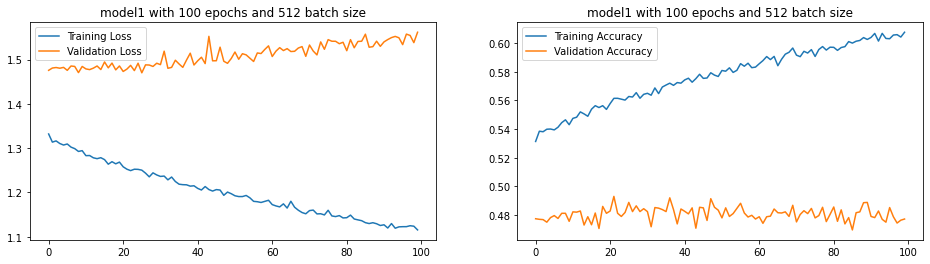

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.47      0.53      1000
           1       0.58      0.61      0.60      1000
           2       0.35      0.41      0.38      1000
           3       0.34      0.33      0.33      1000
           4       0.45      0.41      0.43      1000
           5       0.43      0.32      0.37      1000
           6       0.52      0.56      0.54      1000
           7       0.49      0.60      0.54      1000
           8       0.53      0.72      0.61      1000
           9       0.60      0.44      0.51      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     10000

Accuracy Score: 0.4867
Root Mean Square Error: 3.1107073150651767


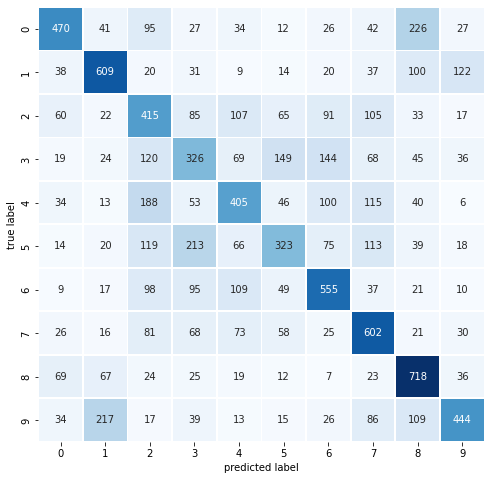

In [84]:
result1_1 = compile_train_plot_model(model1, 100, 512)

In [85]:
new_col = ['DNN with 2 layers (no regularization)']   
result1_1.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result1_1, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512


## Experiment 2: DNN with 3 layers (no regularization)

In [86]:
model2 = models.Sequential()
model2.add(layers.InputLayer(input_shape=(32, 32, 3)))
model2.add(layers.Flatten(name ='flatten'))
model2.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 hidden_layer2 (Dense)       (None, 384)               147840    
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,331,722
Trainable params: 1,331,722
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 4s 7ms/step - loss: 1.8959 - accuracy: 0.3170 - val_loss: 1.7444 - val_accuracy: 0.3768
Epoch 2/20
450/450 [==============================] - 3s 7ms/step - loss: 1.6891 - accuracy: 0.3951 - val_loss: 1.7086 - val_accuracy: 0.3868
Epoch 3/20
450/450 [==============================] - 3s 7ms/step - loss: 1.6028 - accuracy: 0.4295 - val_loss: 1.6595 - val_accuracy: 0.3962
Epoch 4/20
450/450 [==============================] - 3s 6ms/step - loss: 1.5452 - accuracy: 0.4538 - val_loss: 1.5350 - val_accuracy: 0.4486
Epoch 5/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5026 - accuracy: 0.4648 - val_loss: 1.5660 - val_accuracy: 0.4394
Epoch 6/20
450/450 [==============================] - 2s 5ms/step - loss: 1.4595 - accuracy: 0.4802 - val_loss: 1.5099 - val_accuracy: 0.4500
Epoch 7/20
450/450 [==============================] - 2s 5ms/step - loss: 1.4414 - accuracy: 0.4881 - val_loss: 1.4883 - val_accuracy: 0.4644
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

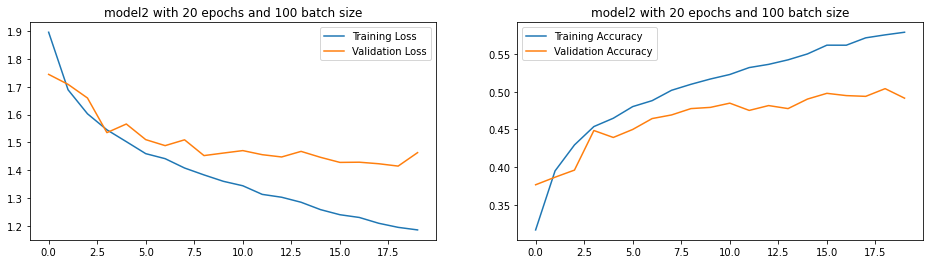

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.62      0.57      1000
           1       0.63      0.53      0.57      1000
           2       0.36      0.41      0.38      1000
           3       0.34      0.28      0.31      1000
           4       0.54      0.31      0.40      1000
           5       0.43      0.39      0.41      1000
           6       0.56      0.56      0.56      1000
           7       0.54      0.62      0.58      1000
           8       0.56      0.68      0.61      1000
           9       0.51      0.62      0.56      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000

Accuracy Score: 0.502
Root Mean Square Error: 3.1441851090544906


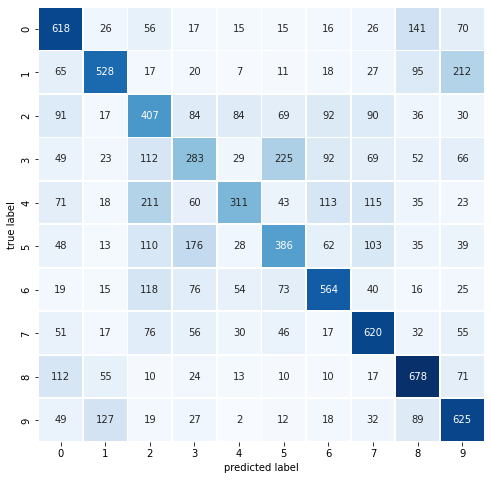

In [87]:
result2 = compile_train_plot_model(model2,20,100) 

In [88]:
new_col = ['DNN with 3 layers (no regularization)']   
result2.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result2, ignore_index = True)

assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100


Epoch 1/100
88/88 [==============================] - 2s 13ms/step - loss: 1.0902 - accuracy: 0.6138 - val_loss: 1.4166 - val_accuracy: 0.5088
Epoch 2/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0649 - accuracy: 0.6236 - val_loss: 1.3983 - val_accuracy: 0.5144
Epoch 3/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0487 - accuracy: 0.6293 - val_loss: 1.4072 - val_accuracy: 0.5188
Epoch 4/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0356 - accuracy: 0.6349 - val_loss: 1.4109 - val_accuracy: 0.5184
Epoch 5/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0261 - accuracy: 0.6368 - val_loss: 1.4196 - val_accuracy: 0.5168
Epoch 6/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0185 - accuracy: 0.6392 - val_loss: 1.4195 - val_accuracy: 0.5188
Epoch 7/100
88/88 [==============================] - 1s 10ms/step - loss: 1.0108 - accuracy: 0.6435 - val_loss: 1.4387 - val_accuracy: 0.5106
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

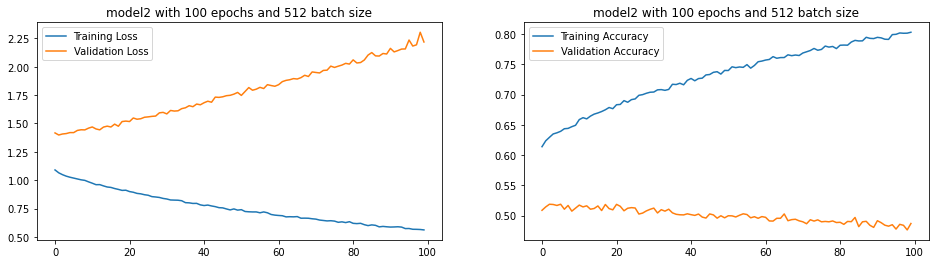

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.53      0.56      1000
           1       0.56      0.59      0.57      1000
           2       0.39      0.36      0.37      1000
           3       0.32      0.34      0.33      1000
           4       0.42      0.44      0.43      1000
           5       0.40      0.40      0.40      1000
           6       0.53      0.57      0.55      1000
           7       0.58      0.54      0.56      1000
           8       0.60      0.64      0.62      1000
           9       0.56      0.53      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000

Accuracy Score: 0.4936
Root Mean Square Error: 3.0848014522818157


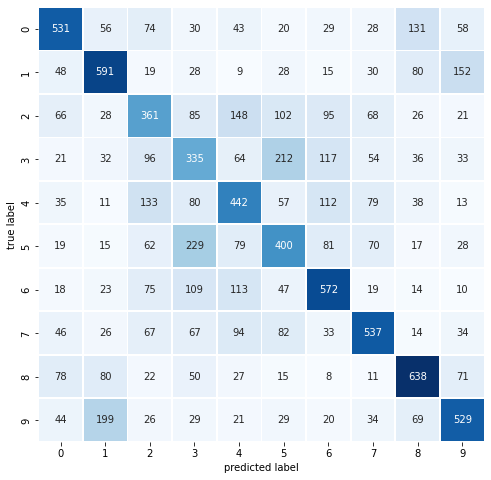

In [89]:
result2_2 = compile_train_plot_model(model2,100,512) 

In [90]:
new_col = ['DNN with 3 layers (no regularization)']   
result2_2.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result2_2, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),0.561593,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512


## Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

In [91]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model3.add(layers.MaxPool2D((2, 2),strides=2))
#model3.add(layers.Dropout(0.3))
model3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model3.add(layers.Dropout(0.3))
model3.add(layers.Flatten())
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(units=384, activation=tf.nn.relu))
model3.add(layers.Dense(units=10, activation=tf.nn.softmax))

model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 9216)           

Epoch 1/20
450/450 [==============================] - 14s 30ms/step - loss: 1.2045 - accuracy: 0.5772 - val_loss: 1.4991 - val_accuracy: 0.5476
Epoch 2/20
450/450 [==============================] - 15s 34ms/step - loss: 0.8228 - accuracy: 0.7141 - val_loss: 1.2466 - val_accuracy: 0.6082
Epoch 3/20
450/450 [==============================] - 13s 29ms/step - loss: 0.6116 - accuracy: 0.7884 - val_loss: 0.9760 - val_accuracy: 0.6808
Epoch 4/20
450/450 [==============================] - 13s 28ms/step - loss: 0.4395 - accuracy: 0.8478 - val_loss: 1.1595 - val_accuracy: 0.6722
Epoch 5/20
450/450 [==============================] - 13s 30ms/step - loss: 0.3061 - accuracy: 0.8938 - val_loss: 1.3505 - val_accuracy: 0.6348
Epoch 6/20
450/450 [==============================] - 13s 29ms/step - loss: 0.2011 - accuracy: 0.9310 - val_loss: 1.2000 - val_accuracy: 0.6996
Epoch 7/20
450/450 [==============================] - 13s 28ms/step - loss: 0.1401 - accuracy: 0.9535 - val_loss: 1.3348 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

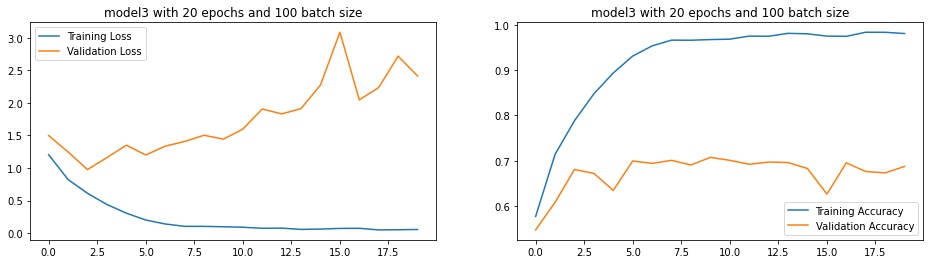

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1000
           1       0.80      0.78      0.79      1000
           2       0.70      0.50      0.58      1000
           3       0.53      0.51      0.52      1000
           4       0.67      0.64      0.66      1000
           5       0.67      0.54      0.60      1000
           6       0.82      0.71      0.76      1000
           7       0.73      0.73      0.73      1000
           8       0.67      0.89      0.76      1000
           9       0.59      0.86      0.70      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.68     10000
weighted avg       0.69      0.69      0.68     10000

Accuracy Score: 0.6862
Root Mean Square Error: 2.4507141816213496


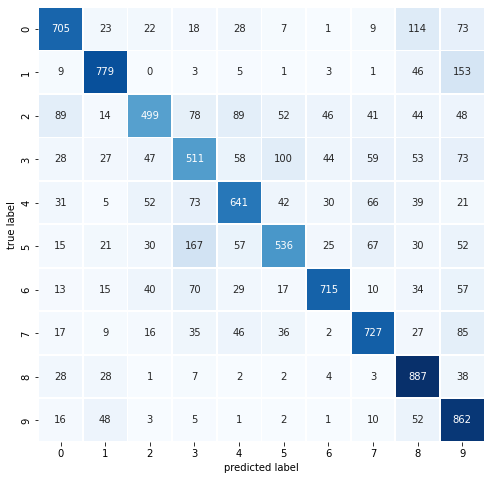

In [92]:
result3 = compile_train_plot_model(model3, 20, 100)

In [93]:
new_col = ['CNN with 2 convolution/max pooling layers (no regularization)']   
result3.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result3, ignore_index = True)

assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),0.561593,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,0.055110,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100


Epoch 1/100
88/88 [==============================] - 10s 102ms/step - loss: 0.0149 - accuracy: 0.9951 - val_loss: 2.0768 - val_accuracy: 0.7216
Epoch 2/100
88/88 [==============================] - 9s 100ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 2.1695 - val_accuracy: 0.7178
Epoch 3/100
88/88 [==============================] - 9s 98ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 2.1276 - val_accuracy: 0.7276
Epoch 4/100
88/88 [==============================] - 9s 99ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 2.0947 - val_accuracy: 0.7358
Epoch 5/100
88/88 [==============================] - 9s 98ms/step - loss: 4.8197e-04 - accuracy: 1.0000 - val_loss: 2.0689 - val_accuracy: 0.7392
Epoch 6/100
88/88 [==============================] - 9s 98ms/step - loss: 1.9739e-04 - accuracy: 1.0000 - val_loss: 2.0963 - val_accuracy: 0.7400
Epoch 7/100
88/88 [==============================] - 9s 98ms/step - loss: 1.3804e-04 - accuracy: 1.0000 - val_loss: 2.1245 - val_accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

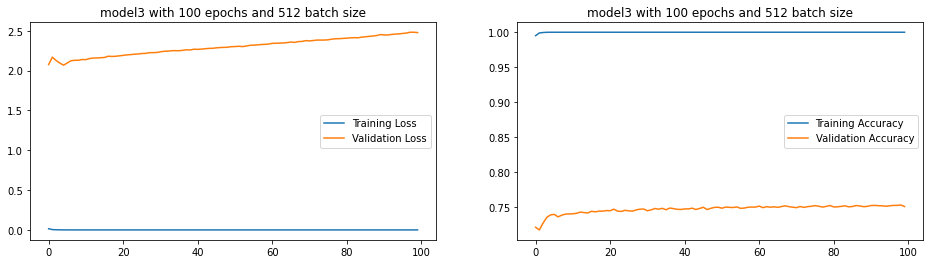

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1000
           1       0.85      0.84      0.84      1000
           2       0.68      0.64      0.66      1000
           3       0.58      0.56      0.57      1000
           4       0.71      0.72      0.71      1000
           5       0.66      0.66      0.66      1000
           6       0.79      0.84      0.81      1000
           7       0.81      0.77      0.79      1000
           8       0.84      0.84      0.84      1000
           9       0.81      0.82      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

Accuracy Score: 0.7488
Root Mean Square Error: 2.0743432695675033


,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101e+00,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529e+00,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295e+00,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),5.615929e-01,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,5.511032e-02,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100
5,CNN with 2 convolution/max pooling layers (no ...,7.557439e-07,1.000000,2.478222,0.7512,2.500861,0.7488,873.627389,100,512


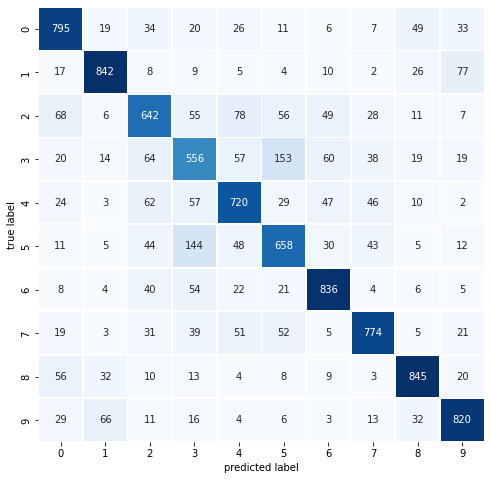

In [94]:
result3_2 = compile_train_plot_model(model3,100,512) 

new_col = ['CNN with 2 convolution/max pooling layers (no regularization)']   
result3_2.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result3_2, ignore_index = True)
assignment_result_table

## Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

In [95]:
model4 = models.Sequential()
model4.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model4.add(layers.MaxPool2D((2, 2),strides=2))
#model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model4.add(layers.Dropout(0.3))
model4.add(layers.Flatten())
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(units=384, activation=tf.nn.relu))
model4.add(layers.Dense(units=10, activation=tf.nn.softmax))

model4.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 2, 2, 512)      

Epoch 1/20
450/450 [==============================] - 17s 36ms/step - loss: 1.2493 - accuracy: 0.5577 - val_loss: 1.4116 - val_accuracy: 0.5140
Epoch 2/20
450/450 [==============================] - 15s 34ms/step - loss: 0.8911 - accuracy: 0.6901 - val_loss: 1.3817 - val_accuracy: 0.5460
Epoch 3/20
450/450 [==============================] - 15s 34ms/step - loss: 0.7213 - accuracy: 0.7472 - val_loss: 1.4744 - val_accuracy: 0.6056
Epoch 4/20
450/450 [==============================] - 15s 34ms/step - loss: 0.5930 - accuracy: 0.7918 - val_loss: 1.0882 - val_accuracy: 0.6520
Epoch 5/20
450/450 [==============================] - 15s 34ms/step - loss: 0.4906 - accuracy: 0.8281 - val_loss: 1.1961 - val_accuracy: 0.6732
Epoch 6/20
450/450 [==============================] - 15s 34ms/step - loss: 0.3958 - accuracy: 0.8610 - val_loss: 1.0903 - val_accuracy: 0.6928
Epoch 7/20
450/450 [==============================] - 15s 34ms/step - loss: 0.3131 - accuracy: 0.8904 - val_loss: 1.1507 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

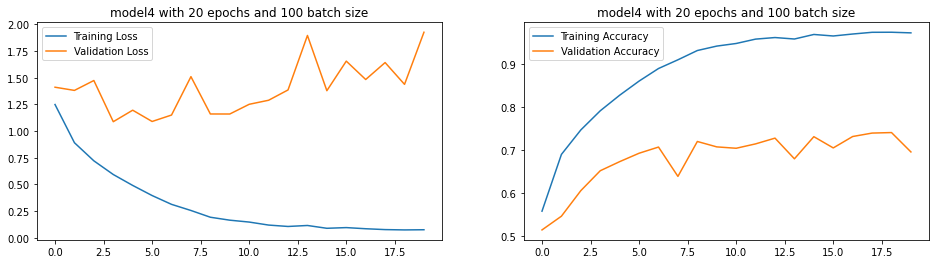

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.89      0.68      1000
           1       0.93      0.77      0.84      1000
           2       0.79      0.39      0.52      1000
           3       0.60      0.42      0.50      1000
           4       0.64      0.74      0.69      1000
           5       0.62      0.69      0.65      1000
           6       0.83      0.72      0.77      1000
           7       0.73      0.82      0.77      1000
           8       0.86      0.73      0.79      1000
           9       0.72      0.87      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.70     10000
weighted avg       0.73      0.71      0.70     10000

Accuracy Score: 0.7057
Root Mean Square Error: 2.3775828061289475


,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101e+00,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529e+00,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295e+00,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),5.615929e-01,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,5.511032e-02,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100
5,CNN with 2 convolution/max pooling layers (no ...,7.557439e-07,1.000000,2.478222,0.7512,2.500861,0.7488,873.627389,100,512
6,CNN with 3 convolution/max pooling layers (no ...,7.509782e-02,0.973467,1.927076,0.6958,1.870737,0.7057,329.292326,20,100


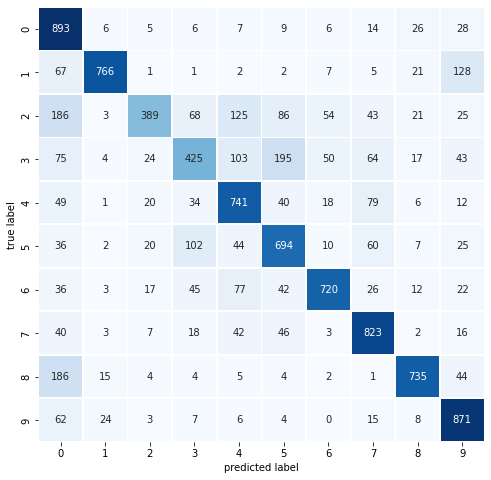

In [96]:
result4 = compile_train_plot_model(model4, 20, 100)

new_col = ['CNN with 3 convolution/max pooling layers (no regularization)']   
result4.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result4, ignore_index = True)
assignment_result_table

Epoch 1/100
88/88 [==============================] - 11s 121ms/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 1.5403 - val_accuracy: 0.7536
Epoch 2/100
88/88 [==============================] - 10s 118ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 1.5171 - val_accuracy: 0.7616
Epoch 3/100
88/88 [==============================] - 10s 117ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 1.5103 - val_accuracy: 0.7658
Epoch 4/100
88/88 [==============================] - 10s 117ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 1.4804 - val_accuracy: 0.7742
Epoch 5/100
88/88 [==============================] - 10s 117ms/step - loss: 4.7547e-04 - accuracy: 1.0000 - val_loss: 1.4942 - val_accuracy: 0.7784
Epoch 6/100
88/88 [==============================] - 10s 117ms/step - loss: 2.8235e-04 - accuracy: 1.0000 - val_loss: 1.5166 - val_accuracy: 0.7784
Epoch 7/100
88/88 [==============================] - 10s 117ms/step - loss: 2.0483e-04 - accuracy: 1.0000 - val_loss: 1.5480 - v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

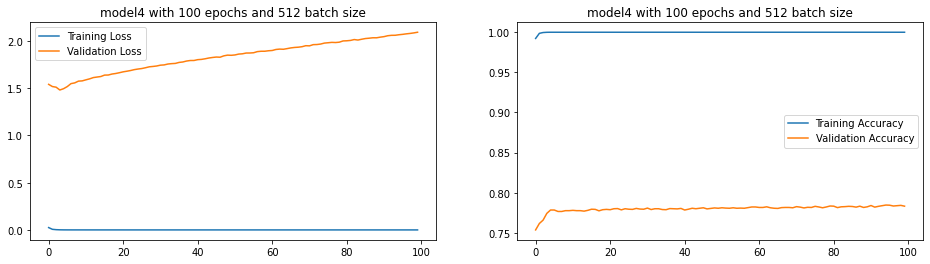

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1000
           1       0.87      0.89      0.88      1000
           2       0.71      0.66      0.68      1000
           3       0.61      0.59      0.60      1000
           4       0.73      0.77      0.75      1000
           5       0.70      0.69      0.69      1000
           6       0.81      0.84      0.82      1000
           7       0.82      0.82      0.82      1000
           8       0.85      0.86      0.85      1000
           9       0.84      0.85      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.77      0.78      0.78     10000
weighted avg       0.77      0.78      0.78     10000

Accuracy Score: 0.7763
Root Mean Square Error: 1.93238194982255


,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101e+00,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529e+00,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295e+00,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),5.615929e-01,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,5.511032e-02,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100
5,CNN with 2 convolution/max pooling layers (no ...,7.557439e-07,1.000000,2.478222,0.7512,2.500861,0.7488,873.627389,100,512
6,CNN with 3 convolution/max pooling layers (no ...,7.509782e-02,0.973467,1.927076,0.6958,1.870737,0.7057,329.292326,20,100
7,CNN with 3 convolution/max pooling layers (no ...,7.340093e-07,1.000000,2.091598,0.7832,2.081923,0.7763,1048.052253,100,512


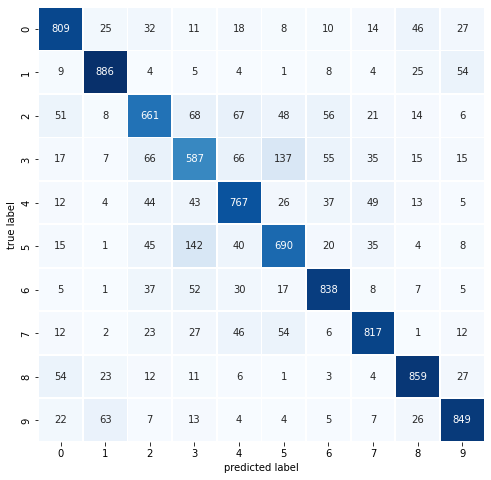

In [97]:
result4_2 = compile_train_plot_model(model4,100,512) 

new_col = ['CNN with 3 convolution/max pooling layers (no regularization)']   
result4_2.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result4_2, ignore_index = True)
assignment_result_table

## Experiment 5+ : You will conduct several more experiments. 

(a) Redo all the 4 experiments with some regularization technique. 


Epoch 1/100
88/88 [==============================] - 2s 12ms/step - loss: 2.8336 - accuracy: 0.2270 - val_loss: 2.3803 - val_accuracy: 0.3268
Epoch 2/100
88/88 [==============================] - 1s 9ms/step - loss: 2.3025 - accuracy: 0.3133 - val_loss: 2.1944 - val_accuracy: 0.3510
Epoch 3/100
88/88 [==============================] - 1s 9ms/step - loss: 2.1566 - accuracy: 0.3350 - val_loss: 2.0630 - val_accuracy: 0.3480
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 2.0509 - accuracy: 0.3515 - val_loss: 1.9618 - val_accuracy: 0.3832
Epoch 5/100
88/88 [==============================] - 1s 9ms/step - loss: 1.9827 - accuracy: 0.3596 - val_loss: 1.8998 - val_accuracy: 0.3850
Epoch 6/100
88/88 [==============================] - 1s 9ms/step - loss: 1.9263 - accuracy: 0.3661 - val_loss: 1.8833 - val_accuracy: 0.3756
Epoch 7/100
88/88 [==============================] - 1s 9ms/step - loss: 1.8932 - accuracy: 0.3682 - val_loss: 1.8413 - val_accuracy: 0.3924
Epoch 8/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

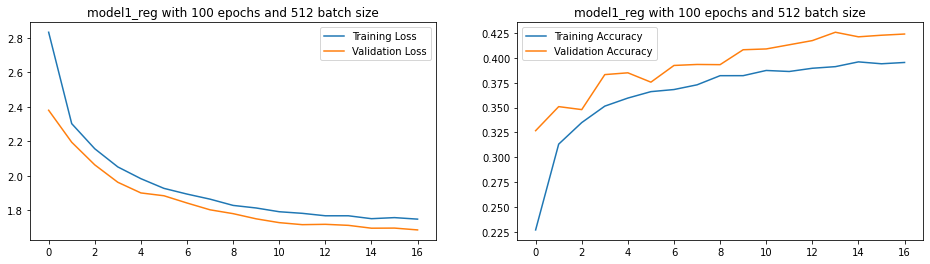

In [98]:
model1_reg = models.Sequential()
model1_reg.add(layers.InputLayer(input_shape=(32, 32, 3)))
model1_reg.add(layers.Flatten(name ='flatten'))
model1_reg.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1_reg.add(layers.Dropout(0.3))
model1_reg.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

result1_reg = compile_train_model_with_reg(model1_reg, 100, 512)

In [99]:
new_col = ['DNN with 2 layers (with regularization)']   
result1_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result1_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101e+00,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529e+00,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295e+00,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),5.615929e-01,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,5.511032e-02,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100
5,CNN with 2 convolution/max pooling layers (no ...,7.557439e-07,1.000000,2.478222,0.7512,2.500861,0.7488,873.627389,100,512
6,CNN with 3 convolution/max pooling layers (no ...,7.509782e-02,0.973467,1.927076,0.6958,1.870737,0.7057,329.292326,20,100
7,CNN with 3 convolution/max pooling layers (no ...,7.340093e-07,1.000000,2.091598,0.7832,2.081923,0.7763,1048.052253,100,512
8,DNN with 2 layers (with regularization),1.747509e+00,0.395400,1.684858,0.4240,1.665038,0.4335,17.461783,100,512


Epoch 1/100
88/88 [==============================] - 2s 13ms/step - loss: 2.8485 - accuracy: 0.2426 - val_loss: 2.3923 - val_accuracy: 0.3352
Epoch 2/100
88/88 [==============================] - 1s 10ms/step - loss: 2.3026 - accuracy: 0.3200 - val_loss: 2.1155 - val_accuracy: 0.3626
Epoch 3/100
88/88 [==============================] - 1s 11ms/step - loss: 2.1164 - accuracy: 0.3378 - val_loss: 1.9875 - val_accuracy: 0.3788
Epoch 4/100
88/88 [==============================] - 1s 10ms/step - loss: 1.9901 - accuracy: 0.3604 - val_loss: 1.9119 - val_accuracy: 0.3814
Epoch 5/100
88/88 [==============================] - 1s 11ms/step - loss: 1.9177 - accuracy: 0.3686 - val_loss: 1.8195 - val_accuracy: 0.3992
Epoch 6/100
88/88 [==============================] - 1s 10ms/step - loss: 1.8643 - accuracy: 0.3745 - val_loss: 1.7908 - val_accuracy: 0.4088
Epoch 7/100
88/88 [==============================] - 1s 10ms/step - loss: 1.8456 - accuracy: 0.3722 - val_loss: 1.7582 - val_accuracy: 0.4124
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

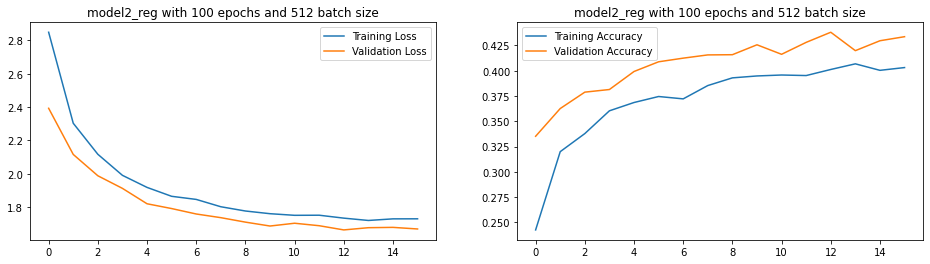

In [100]:
model2_reg = models.Sequential()
model2_reg.add(layers.InputLayer(input_shape=(32, 32, 3)))
model2_reg.add(layers.Flatten(name ='flatten'))
model2_reg.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2_reg.add(layers.Dropout(0.3))
model2_reg.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2_reg.add(layers.Dropout(0.3))
model2_reg.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

result2_reg = compile_train_model_with_reg(model2_reg, 100, 512)

In [101]:
new_col = ['DNN with 3 layers (with regularization)']   
result2_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result2_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101e+00,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529e+00,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295e+00,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),5.615929e-01,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,5.511032e-02,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100
5,CNN with 2 convolution/max pooling layers (no ...,7.557439e-07,1.000000,2.478222,0.7512,2.500861,0.7488,873.627389,100,512
6,CNN with 3 convolution/max pooling layers (no ...,7.509782e-02,0.973467,1.927076,0.6958,1.870737,0.7057,329.292326,20,100
7,CNN with 3 convolution/max pooling layers (no ...,7.340093e-07,1.000000,2.091598,0.7832,2.081923,0.7763,1048.052253,100,512
8,DNN with 2 layers (with regularization),1.747509e+00,0.395400,1.684858,0.4240,1.665038,0.4335,17.461783,100,512
9,DNN with 3 layers (with regularization),1.729271e+00,0.403089,1.668270,0.4336,1.645949,0.4445,18.781139,100,512


Epoch 1/100
88/88 [==============================] - 11s 112ms/step - loss: 2.1512 - accuracy: 0.4715 - val_loss: 2.7080 - val_accuracy: 0.3702
Epoch 2/100
88/88 [==============================] - 9s 108ms/step - loss: 1.4580 - accuracy: 0.6350 - val_loss: 2.4497 - val_accuracy: 0.4268
Epoch 3/100
88/88 [==============================] - 10s 108ms/step - loss: 1.1778 - accuracy: 0.6984 - val_loss: 2.2146 - val_accuracy: 0.6330
Epoch 4/100
88/88 [==============================] - 10s 108ms/step - loss: 1.0178 - accuracy: 0.7415 - val_loss: 1.8656 - val_accuracy: 0.7132
Epoch 5/100
88/88 [==============================] - 10s 108ms/step - loss: 0.9204 - accuracy: 0.7738 - val_loss: 1.4240 - val_accuracy: 0.7082
Epoch 6/100
88/88 [==============================] - 9s 108ms/step - loss: 0.8592 - accuracy: 0.7968 - val_loss: 1.1796 - val_accuracy: 0.7268
Epoch 7/100
88/88 [==============================] - 9s 108ms/step - loss: 0.8172 - accuracy: 0.8185 - val_loss: 1.0686 - val_accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

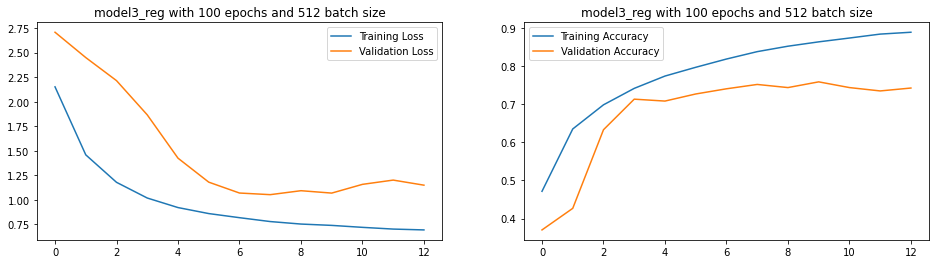

In [102]:
model3_reg = models.Sequential()
model3_reg.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model3_reg.add(layers.MaxPool2D((2, 2),strides=2))
model3_reg.add(layers.Dropout(0.3))
model3_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model3_reg.add(layers.Dropout(0.3))
model3_reg.add(layers.Flatten())
model3_reg.add(layers.BatchNormalization())
model3_reg.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model3_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

result3_reg = compile_train_model_with_reg(model3_reg, 100, 512)

In [104]:
new_col = ['CNN with 2 convolution/max pooling layers (with regularization)']   
result3_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result3_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101e+00,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529e+00,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295e+00,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),5.615929e-01,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,5.511032e-02,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100
5,CNN with 2 convolution/max pooling layers (no ...,7.557439e-07,1.000000,2.478222,0.7512,2.500861,0.7488,873.627389,100,512
6,CNN with 3 convolution/max pooling layers (no ...,7.509782e-02,0.973467,1.927076,0.6958,1.870737,0.7057,329.292326,20,100
7,CNN with 3 convolution/max pooling layers (no ...,7.340093e-07,1.000000,2.091598,0.7832,2.081923,0.7763,1048.052253,100,512
8,DNN with 2 layers (with regularization),1.747509e+00,0.395400,1.684858,0.4240,1.665038,0.4335,17.461783,100,512
9,DNN with 3 layers (with regularization),1.729271e+00,0.403089,1.668270,0.4336,1.645949,0.4445,18.781139,100,512


Epoch 1/100
88/88 [==============================] - 13s 133ms/step - loss: 2.1801 - accuracy: 0.4004 - val_loss: 2.5283 - val_accuracy: 0.4124
Epoch 2/100
88/88 [==============================] - 11s 129ms/step - loss: 1.5227 - accuracy: 0.5736 - val_loss: 2.2445 - val_accuracy: 0.4872
Epoch 3/100
88/88 [==============================] - 11s 129ms/step - loss: 1.2410 - accuracy: 0.6394 - val_loss: 1.9188 - val_accuracy: 0.5876
Epoch 4/100
88/88 [==============================] - 11s 129ms/step - loss: 1.0724 - accuracy: 0.6848 - val_loss: 1.6050 - val_accuracy: 0.6182
Epoch 5/100
88/88 [==============================] - 11s 128ms/step - loss: 0.9613 - accuracy: 0.7125 - val_loss: 1.2234 - val_accuracy: 0.6774
Epoch 6/100
88/88 [==============================] - 11s 129ms/step - loss: 0.8679 - accuracy: 0.7394 - val_loss: 0.9362 - val_accuracy: 0.7340
Epoch 7/100
88/88 [==============================] - 11s 129ms/step - loss: 0.8117 - accuracy: 0.7535 - val_loss: 0.8410 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

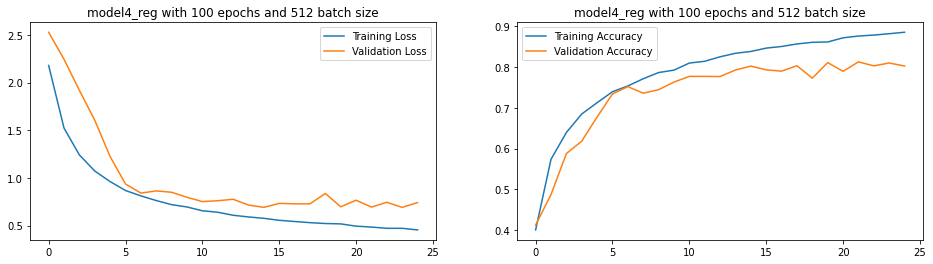

In [103]:
model4_reg = models.Sequential()
model4_reg.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model4_reg.add(layers.MaxPool2D((2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Flatten())
model4_reg.add(layers.BatchNormalization())
model4_reg.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model4_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

result4_reg = compile_train_model_with_reg(model4_reg, 100, 512)


In [105]:
new_col = ['CNN with 3 convolution/max pooling layers (with regularization)']   
result4_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result4_reg, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs,batch_size
0,DNN with 2 layers (no regularization),1.377101e+00,0.515000,1.505522,0.4720,1.467557,0.4785,55.771641,20,100
1,DNN with 2 layers (no regularization),1.115529e+00,0.607578,1.561750,0.4772,1.518324,0.4867,95.816992,100,512
2,DNN with 3 layers (no regularization),1.185295e+00,0.578644,1.463116,0.4914,1.427629,0.5020,59.932398,20,100
3,DNN with 3 layers (no regularization),5.615929e-01,0.802867,2.218202,0.4870,2.172855,0.4936,145.161441,100,512
4,CNN with 2 convolution/max pooling layers (no ...,5.511032e-02,0.980667,2.413625,0.6876,2.395263,0.6862,266.018741,20,100
5,CNN with 2 convolution/max pooling layers (no ...,7.557439e-07,1.000000,2.478222,0.7512,2.500861,0.7488,873.627389,100,512
6,CNN with 3 convolution/max pooling layers (no ...,7.509782e-02,0.973467,1.927076,0.6958,1.870737,0.7057,329.292326,20,100
7,CNN with 3 convolution/max pooling layers (no ...,7.340093e-07,1.000000,2.091598,0.7832,2.081923,0.7763,1048.052253,100,512
8,DNN with 2 layers (with regularization),1.747509e+00,0.395400,1.684858,0.4240,1.665038,0.4335,17.461783,100,512
9,DNN with 3 layers (with regularization),1.729271e+00,0.403089,1.668270,0.4336,1.645949,0.4445,18.781139,100,512


In [106]:
assignment_result_table.to_csv('assignment2_result1.csv')

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [45]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/model_0.7224.h5')

In [46]:
preds = model.predict(x_test_norm)

In [47]:
preds.shape

(10000, 10)

### Predictions

In [48]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [49]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.00%,0.00%,0.00%,99.10%,0.00%,0.89%,0.01%,0.00%,0.00%,0.00%
1,0.02%,44.51%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,55.47%,0.00%
2,2.58%,0.92%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,96.50%,0.00%
3,99.76%,0.00%,0.07%,0.03%,0.00%,0.00%,0.00%,0.00%,0.14%,0.00%
4,0.00%,0.00%,0.23%,2.21%,96.68%,0.00%,0.87%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,99.98%,0.00%,0.00%,0.00%
6,0.00%,99.99%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%
7,0.00%,0.00%,1.91%,0.11%,0.11%,0.01%,97.86%,0.00%,0.00%,0.00%
8,0.02%,0.00%,0.00%,94.18%,0.34%,5.16%,0.29%,0.01%,0.00%,0.00%
9,0.00%,99.38%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.62%


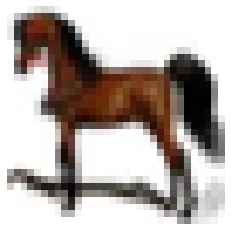

In [50]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [51]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [52]:
activations = activation_model.predict(img_tensor)
len(activations)

8

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 batch_normalization (BatchN  (None, 9216)             3

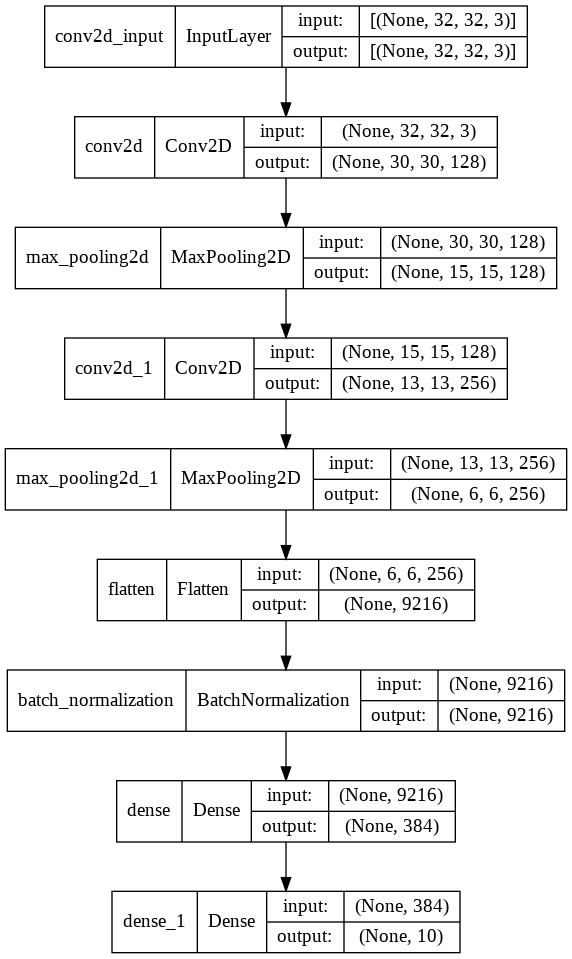

In [53]:
model.summary()

keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [54]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'batch_normalization',
 'dense',
 'dense_1']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


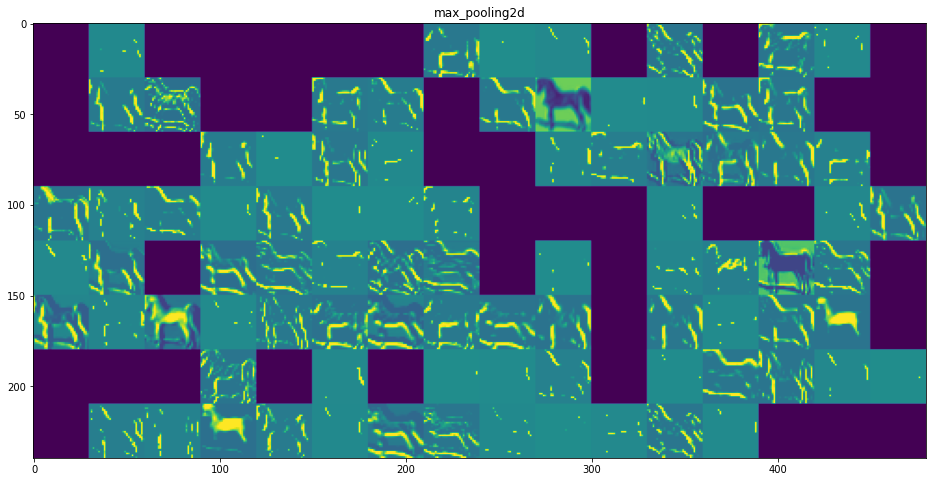

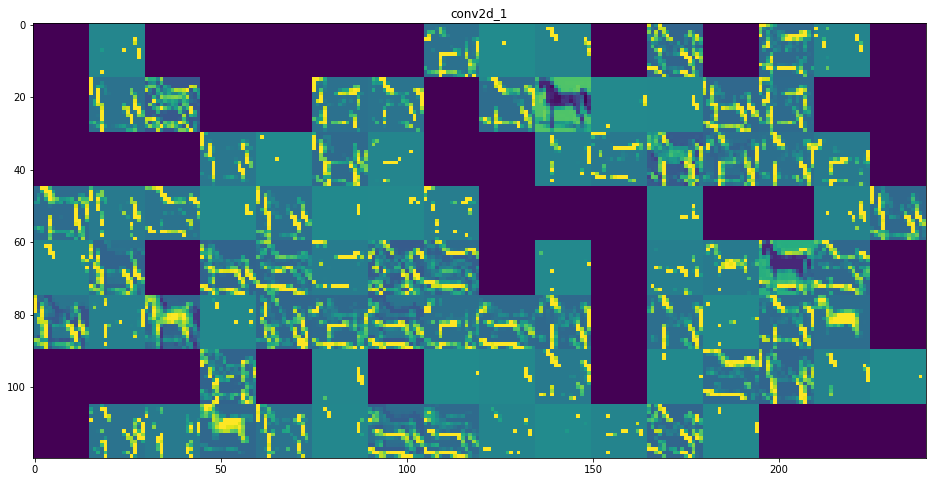

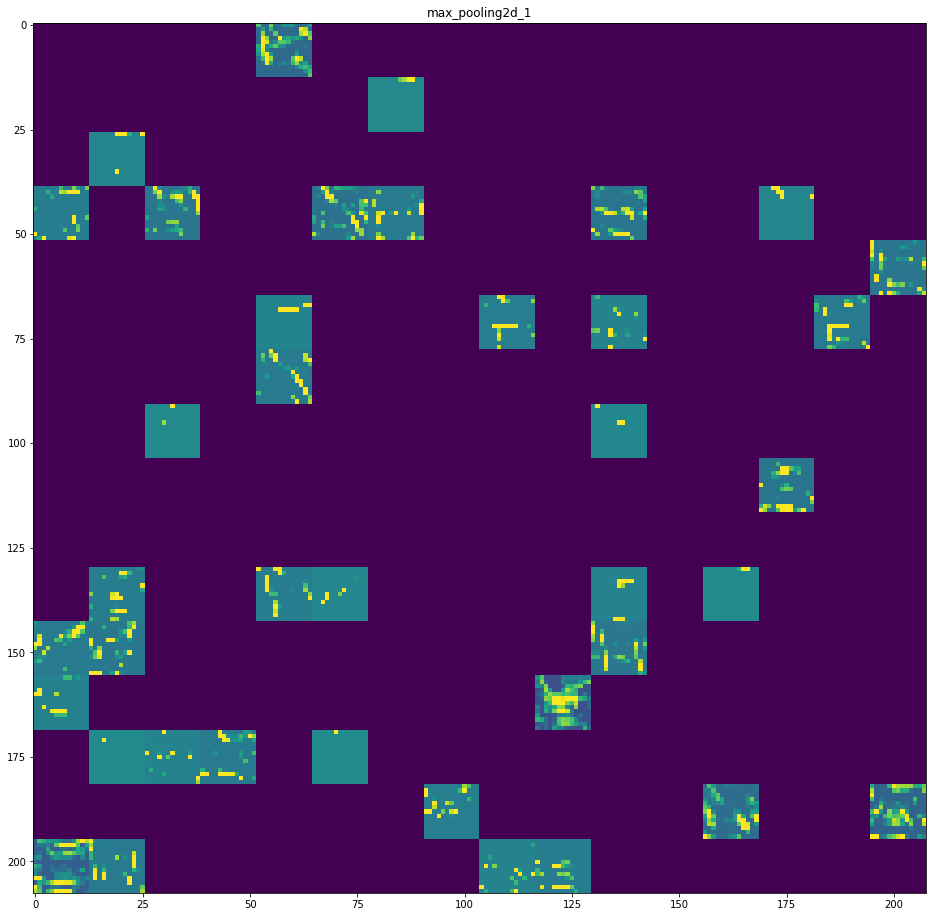

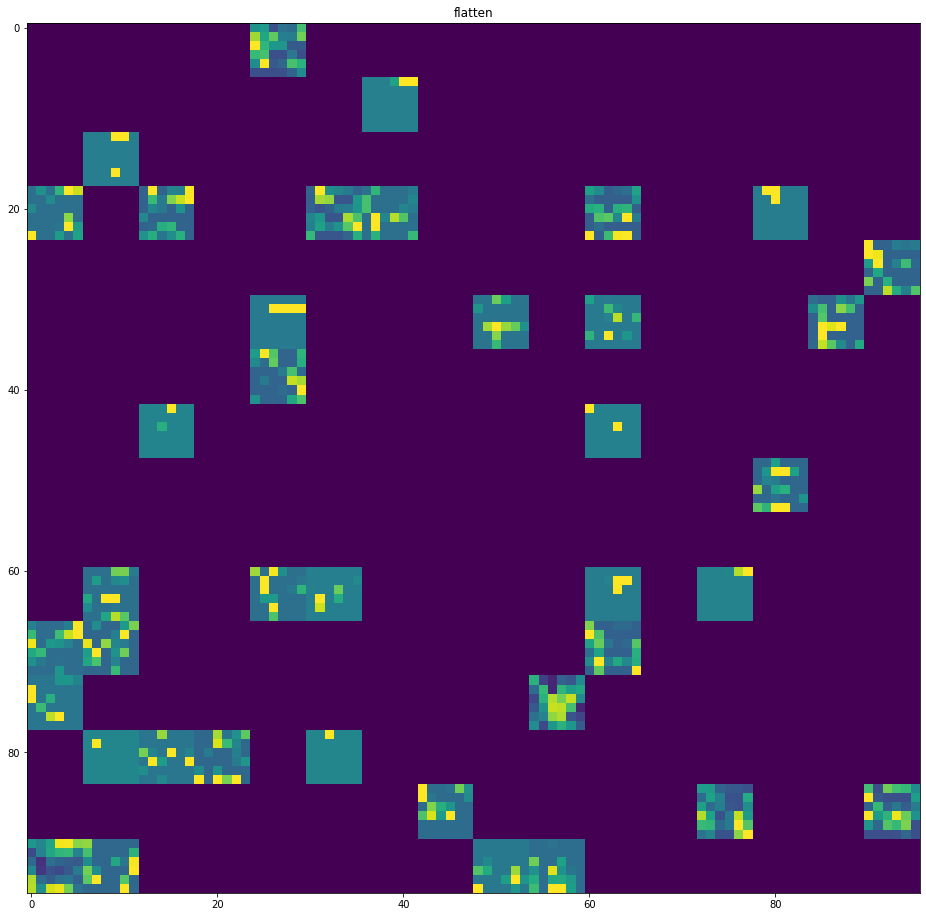

In [55]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map #128
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features) #15
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix 
    n_cols = n_features // images_per_row #8
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();